In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
project_dir = "/codespace/braintypicality"
sys.path.append(project_dir)

In [2]:
import glob
import math
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn

from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sde_lib
from models import ncsnpp3d
from models import utils as mutils
from models.ema import ExponentialMovingAverage
from utils import restore_checkpoint, restore_pretrained_weights, save_checkpoint
from configs.ve import biggan_default as configs
config = configs.get_config()
config.msma.denoise=False
config.msma.schedule = "geometric"
config.model.learnable_embedding=True
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"

In [3]:
# https://github.com/gudovskiy/cflow-ad/blob/b2ebf9e673a0aa46992a3b18367ec066a57bba89/model.py
def positionalencoding2d(D, H, W):
    """
    :param D: dimension of the model
    :param H: H of the positions
    :param W: W of the positions
    :return: DxHxW position matrix
    """
    if D % 4 != 0:
        raise ValueError(
            "Cannot use sin/cos positional encoding with odd dimension (got dim={:d})".format(
                D
            )
        )
    P = torch.zeros(D, H, W)
    # Each dimension use half of D
    D = D // 2
    div_term = torch.exp(torch.arange(0.0, D, 2) * -(math.log(1e4) / D))
    pos_w = torch.arange(0.0, W).unsqueeze(1)
    pos_h = torch.arange(0.0, H).unsqueeze(1)
    P[0:D:2, :, :] = (
        torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, H, 1)
    )
    P[1:D:2, :, :] = (
        torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, H, 1)
    )
    P[D::2, :, :] = (
        torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, W)
    )
    P[D + 1 :: 2, :, :] = (
        torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, W)
    )
    return P

def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)

# https://github.com/tatp22/multidim-positional-encoding/blob/master/positional_encodings/torch_encodings.py
class PositionalEncoding3D(nn.Module):
    def __init__(self, embedding_size):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding3D, self).__init__()
        self.embedding_size = embedding_size
        channels = int(np.ceil(embedding_size / 6) * 2)
        if channels % 2:
            channels += 1
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.register_buffer("cached_penc", None)

    def forward(self, tensor):
        """
        :param tensor: A 5d tensor of size (batch_size, ch, x, y, z)
        :return: Positional Encoding Matrix of size (batch_size, ch, x, y, z)
        """
        if len(tensor.shape) != 5:
            raise RuntimeError("The input tensor has to be 5d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc
        
        self.cached_penc = None
        batch_size, _, x, y, z = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        pos_z = torch.arange(z, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        sin_inp_z = torch.einsum("i,j->ij", pos_z, self.inv_freq)
        emb_x = get_emb(sin_inp_x).unsqueeze(1).unsqueeze(1)
        emb_y = get_emb(sin_inp_y).unsqueeze(1)
        emb_z = get_emb(sin_inp_z)
        emb = torch.zeros((x, y, z, self.channels * 3), device=tensor.device).type(
            tensor.type()
        )
        emb[:, :, :, : self.channels] = emb_x
        emb[:, :, :, self.channels : 2 * self.channels] = emb_y
        emb[:, :, :, 2 * self.channels :] = emb_z

        self.cached_penc = emb[None, :, :, :, :self.embedding_size].repeat(batch_size, 1, 1, 1, 1)
        
        # Channels first
        self.cached_penc = self.cached_penc.permute(0,4,1,2,3)
        
        return self.cached_penc

In [4]:
encoder = PositionalEncoding3D(64)
p3d = encoder(torch.empty(3, 10, 32,32,32))
p3d.shape

torch.Size([3, 64, 32, 32, 32])

In [5]:
encoder.embedding_size, encoder.channels

(64, 22)

<AxesSubplot: >

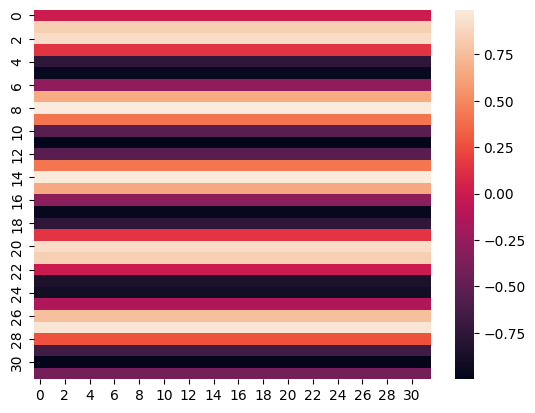

In [6]:
sns.heatmap(p3d[0,0,:,:,0])

In [7]:
torch.isclose(p3d[0], p3d[1]).all()

tensor(True)

In [41]:
class SpatialNorm3D(nn.Module):
    def __init__(self, in_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv = nn.Conv3d(
            in_channels,
            in_channels,
            kernel_size,
            groups=in_channels,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.conv.weight.data.fill_(1)  # all ones weights
        self.conv.weight.requires_grad = False  # freeze weights

    @torch.no_grad()
    def forward(self, x):
        return self.conv(x.square()).pow_(0.5)

In [50]:
n_timesteps = config.model.num_scales
eps = config.msma.min_timestep
end = config.msma.max_timestep
config.msma.n_timesteps = 10
msma_sigmas = torch.exp(
    torch.linspace(
        np.log(max(1e-1, sde.sigma_min)),
        np.log(sde.sigma_max),
        config.msma.n_timesteps,
        device=config.device,
    )
)
timesteps = sde.noise_schedule_inverse(msma_sigmas).to(config.device)

In [53]:
timesteps

tensor([0.0560, 0.1609, 0.2658, 0.3707, 0.4756, 0.5805, 0.6853, 0.7902, 0.8951,
        1.0000], device='cuda:0')

In [110]:
%%time
x = torch.ones(1,2, *config.data.image_size)
s = score_model(x, timesteps[-1:])
s.shape

CPU times: user 234 ms, sys: 8.16 ms, total: 242 ms
Wall time: 27.3 ms


torch.Size([1, 2, 96, 112, 80])

In [59]:
normer = SpatialNorm3D(2)
y = normer(x)
y.shape

torch.Size([1, 2, 48, 56, 40])

In [70]:
conv = SpatialNorm3D(2, kernel_size=7, stride=4, padding=2)
z = conv(y)
z.shape

torch.Size([1, 2, 12, 14, 10])

In [4]:
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from functools import partial
from einops import rearrange
from models.flows import ScoreAttentionBlock, PatchFlow, gaussian_logprob

In [5]:
flow = PatchFlow(input_size=(2, *config.data.image_size), patch_size=17,
                 patch_batch_size=112, global_flow=True).cuda()
flow

Generating 17x17x17 patches from input size: (2, 96, 112, 80)
Pooled spatial resolution: (8, 10, 7)
Number of flows / patches: 560
Global Context Shape:  (2, 7, 9)


PatchFlow(
  (local_pooler): SpatialNorm3D(
    (conv): Conv3d(2, 2, kernel_size=(17, 17, 17), stride=(11, 11, 11), padding=(4, 4, 4), groups=2, bias=False)
  )
  (position_encoder): PositionalEncoding3D()
  (global_pooler): SpatialNorm3D(
    (conv): Conv3d(2, 2, kernel_size=(32, 32, 32), stride=(11, 11, 11), padding=(4, 4, 4), groups=2, bias=False)
  )
  (global_attention): ScoreAttentionBlock(
    (proj): Linear(in_features=2, out_features=128, bias=False)
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=False)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=False)
    )
    (normout): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (flow): SequenceINN(

In [6]:
x = torch.ones(1,2, *config.data.image_size, device="cuda")
x.shape

torch.Size([1, 2, 96, 112, 80])

In [7]:
%%time
z,ldj = flow(x, fast=False)
z.shape

CPU times: user 498 ms, sys: 325 ms, total: 823 ms
Wall time: 1.03 s


torch.Size([560, 1, 2])

In [8]:
%%time
zf,ldjf = flow(x, fast=True)
zf.shape

CPU times: user 8.68 ms, sys: 1.44 ms, total: 10.1 ms
Wall time: 9.86 ms


torch.Size([560, 1, 2])

In [9]:
assert torch.isclose(z, zf, rtol=9e-2).all()
assert torch.isclose(ldj, ldjf, rtol=9e-2).all()

In [10]:
gaussian_logprob(zf, ldjf).shape

torch.Size([560, 1])

In [11]:
b, c, h, w, d = x.shape
y = x.permute(2, 3, 4, 0, 1)  # Patches x batch x channels
y = y.reshape(h*w*d, b, c)
y2 = rearrange(x, 'b c h w d -> (h w d) b c')
assert torch.isclose(y, y2).all()

In [12]:
b, c, h, w, d = x.shape
y = x.permute(2, 3, 4, 0, 1)  # Patches x batch x channels
y = y.reshape(h*w*d, b, c)
y = y.reshape(h*w*d*b, c)
y2 = rearrange(x, 'b c h w d -> (h w d b) c')

assert torch.isclose(y, y2).all()

In [13]:
b, c, h, w, d = x.shape
y = x.permute(2, 3, 4, 0, 1)  # Patches x batch x channels
y = y.reshape(h*w*d, b, c)
y = y.reshape(h*w*d*b, c)
y2 = rearrange(x, 'b c h w d -> (h w d b) c')

# Reshape back after op
y = (y + 1) * 2
y = y.reshape(h,w,d,b, c)
y = y.permute(3,4, 0,1,2)

y2 = (y2 + 1) * 2
y2 = rearrange(y2, '(h w d b) c -> b c h w d', b=b, c=c, h=h, w=w, d=d )

assert torch.isclose(y, y2).all()
assert torch.isclose(y, (x+1)*2).all()
assert torch.isclose(y2, (x+1)*2).all()

In [14]:
opt = torch.optim.Adam(flow.flow.parameters())

In [15]:
%%time
losses = []
for i in tqdm(range(10)):
    losses.append(PatchFlow.stochastic_train_step(flow, x, opt, n_patches=32))

100%|██████████| 10/10 [00:02<00:00,  4.91it/s]

CPU times: user 1.59 s, sys: 405 ms, total: 1.99 s
Wall time: 2.04 s


<AxesSubplot: >

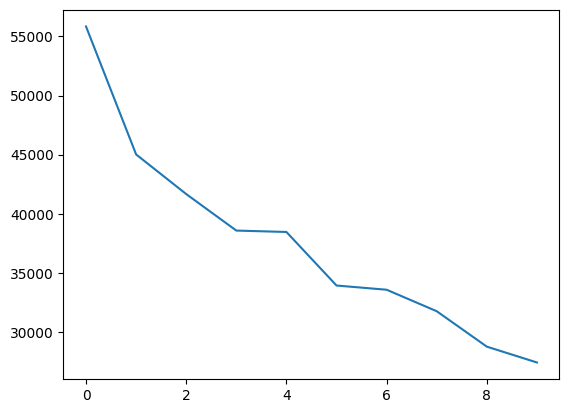

In [16]:
pd.Series(losses).plot()

In [17]:
%%time
with torch.no_grad():
    flow.eval()
    nh,nw,nd = flow.spatial_res 
    z, ldj = flow(x, fast=True)
    xll = flow.logprob(z,ldj)
    xll = rearrange(xll, '(h w d b) 1 -> b h w d', b=b, h=nh, w=nw, d=nd ).cpu()
    xll.shape

CPU times: user 50.1 ms, sys: 3.41 ms, total: 53.5 ms
Wall time: 53.3 ms


In [18]:
xll2 = flow.log_density(x, fast=True).cpu()

In [19]:
assert torch.isclose(xll, xll2).all()

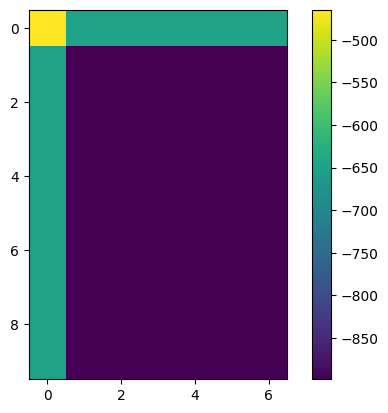

In [20]:
plt.imshow(xll[0, 3,:,:])
plt.colorbar()

## Full training of a flow model

In [21]:
import datasets

config.data.cache_rate=0.0
config.eval.batch_size=8

# Build data pipeline
inlier_ds, ood_ds, _ = datasets.get_dataset(
    config,
    uniform_dequantization=config.data.uniform_dequantization,
    evaluation=True,
    ood_eval=True,
)

# train_ds, eval_ds, _ = datasets.get_dataset(
#     config,
#     uniform_dequantization=config.data.uniform_dequantization,
#     evaluation=True,
# )

/home/amahmood/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:111: FutureWarning:

<class 'monai.transforms.utility.dictionary.AsChannelFirstd'>: Class `AsChannelFirstd` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead.



In [22]:
config.data

as_tfds: false
cache_rate: 0.0
centered: false
colab_path: /content/drive/MyDrive/ML_Datasets/ABCD/processed/
colab_splits_path: /content/drive/MyDrive/Developer/braintypicality/dataset/
colab_tumor_path: /content/drive/MyDrive/ML_Datasets/ABCD/tumor/
dataset: BRAIN
dir_path: /DATA/Users/amahmood/braintyp/processed_v2/
gen_ood: false
image_size: !!python/tuple
- 96
- 112
- 80
num_channels: 2
ood_ds: DS-SA
select_channel: -1
spacing_pix_dim: 2.0
splits_path: /home/braintypicality/dataset/
tumor_dir_path: /DATA/Users/amahmood/tumor/
uniform_dequantization: false

In [23]:
x_batch = next(iter(inlier_ds))["image"]
x_batch.shape

torch.Size([8, 2, 96, 112, 80])

In [24]:
# Initialize score model
score_model = mutils.create_model(config, log_grads=False)
ema = ExponentialMovingAverage(
    score_model.parameters(), decay=config.model.ema_rate
)
state = dict(model=score_model, ema=ema)

# Get the latest score model checkpoint from workdir
checkpoint_dir = os.path.join(workdir, "checkpoints")
checkpoint_paths = glob.glob(os.path.join(checkpoint_dir, "checkpoint_*.pth"))
latest_checkpoint_path = max(
    checkpoint_paths, key=lambda x: int(x.split("_")[-1][1])
)
state = restore_checkpoint(latest_checkpoint_path, state, config.device)
ema.store(score_model.parameters())
ema.copy_to(score_model.parameters())
score_model.eval().requires_grad_(False)

DataParallel(
  (module): SegResNetpp(
    (convInit): Convolution(
      (conv): Conv3d(2, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (down_layers): ModuleDict(
      (resnet_0x2): MultiSequential(
        (0): ResnetBlockBigGANpp(
          (pre_conv): Identity()
          (norm_0): GroupNorm(6, 24, eps=1e-06, affine=True)
          (conv_0): Convolution(
            (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (dense): Linear(in_features=256, out_features=48, bias=True)
          (norm_1): GroupNorm(6, 24, eps=1e-06, affine=True)
          (conv_1): Convolution(
            (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (act): MemoryEfficientSwish()
        )
        (1): ResnetBlockBigGANpp(
          (norm_0): GroupNorm(6, 24, eps=1e-06, affine=True)
          (conv_0): Convolution(
 

In [25]:
score_model.device_ids

[0]

In [26]:
%%time
scorer = mutils.build_score_norm_fn(config, score_model, return_norm=False)

CPU times: user 5.35 ms, sys: 0 ns, total: 5.35 ms
Wall time: 1.3 ms


In [27]:
%%time
x_scores = scorer(x_batch[:8])
x_scores.shape

CPU times: user 14.6 s, sys: 205 ms, total: 14.8 s
Wall time: 5.87 s


torch.Size([8, 20, 96, 112, 80])

In [28]:
import ml_collections

config.flow = ml_collections.ConfigDict(
    dict(patch_size=3,patch_batch_size=112, global_flow=True
))

In [29]:
# Initialize flow model
flow = PatchFlow(
    input_size=(config.msma.n_timesteps, *config.data.image_size),
    patch_size=config.flow.patch_size,
    patch_batch_size=config.flow.patch_batch_size,
    global_flow=config.flow.global_flow,
).cuda()

Generating 3x3x3 patches from input size: (20, 96, 112, 80)
Pooled spatial resolution: (48, 56, 40)
Number of flows / patches: 107520
Global Context Shape:  (20, 24, 28)


In [30]:
x = x_scores.cuda()

In [31]:
%%time
x_scores_ll = flow.log_density(x)
x_scores_ll.shape

CPU times: user 831 ms, sys: 252 ms, total: 1.08 s
Wall time: 1.5 s


torch.Size([8, 48, 56, 40])

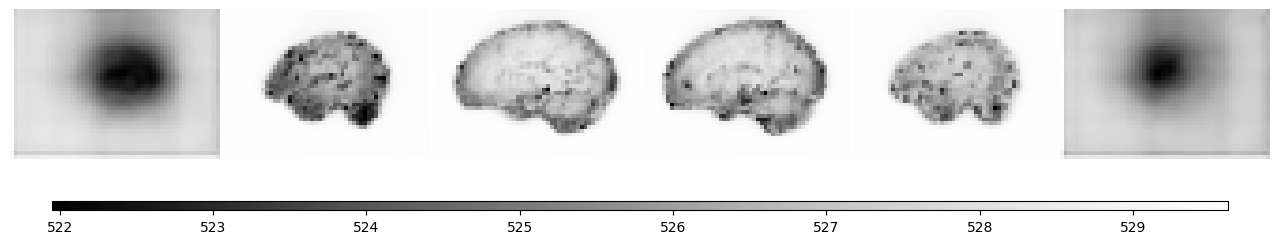

In [32]:
import ants

x_img = ants.from_numpy(x_scores_ll.cpu().numpy()[0])

ants.plot(x_img - x_img.min(), overlay=None,
          nslices=6, overlay_cmap="RdBu", cbar=True, cbar_vertical=False, overlay_alpha=0.6)
